$$ Strategy\: description.$$
$$ Indicator - RSI$$
$$TimeFrame: H1 (1 hour), M1 (1 minute), Period = 28$$
$$ Bias = Main\: instrument RSI - Hedge\: instrument RSI$$
$$ Big \:Bias (BB) = H1's\: Bias$$
$$ Small \:Bias (SB) = M1's \:Bias$$
$$ Treshold:\: min = 8,\: max = 92 $$
$$ Signal:$$
$$ BUY:$$
$$ BB>0 && BB > min && BB < max && SB > min -> buy some value of main, sell some value of hedge $$
$$ SELL:$$
$$BB < 0 && abs(BB) > min && abs(BB) < max && SB < max && abs(SB) > min -> buy some value of hedge, sell some value of main $$

This code takes two dataframes of the main and hedging instrument as input, calculates RSI, bias and buy/sell moments. The main function - cash - calculates the amount of money and its dynamics throughout the backtest. The cash function works with long and short positions, takes into account transaction fees, has a stop loss and take profit parameter, which is calculated based on the average price of the combined long and short positions, as well as various cash limits and not allowing margin calls on short positions. Accepts as input the indicator period (28 by default), the amount of money the user has, the indicator's trash holds, as well as the stop loss/take profit value and a boolean variable that indicates whether stop loss/take profit should be included

For example, the code with parameters period = 28, user_cash = 500k, min_val = 8, max_val = 92, sltp = 0.25, sltp = True will return the final cash in size 1663882.5 ( profit = 232,8 %)

The code with these parameters will run for about 15 minutes, since the prices of traded instruments are high, the start value of the cash is small, and the number of signals is large (the code will often try to bypass the margin call). To speed up the code up to 2-3 minutes - increase the start cash (for example, up to 1000k), or reduce the number of trading moments (min_val = 0.1, max_val = 0.9)

In [1]:
import pandas as pd
from tqdm import tqdm
import copy

In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: <object object at 0x7f827ad68e40>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/georgijgurskij/.conda/envs/dqual/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
main = pd.read_excel('RB(main).xlsx')
hedge = pd.read_excel('hedge.xlsx')

In [4]:
main.head()

,date,open,high,low,close,volume
0,2019-01-02 09:01:00,3398.0,3405.0,3389.0,3400.0,79572.0
1,2019-01-02 09:02:00,3401.0,3430.0,3401.0,3409.0,88858.0
2,2019-01-02 09:03:00,3410.0,3414.0,3409.0,3413.0,22584.0
3,2019-01-02 09:04:00,3412.0,3413.0,3403.0,3405.0,17688.0
4,2019-01-02 09:05:00,3404.0,3409.0,3404.0,3406.0,15522.0


In [5]:
hedge.head()

,date,open,high,low,close,volume
0,2019-01-02 09:01:00,496.5,496.5,492.0,493.5,21786.0
1,2019-01-02 09:02:00,493.5,494.5,492.5,493.0,9238.0
2,2019-01-02 09:03:00,493.0,493.5,492.5,493.5,5824.0
3,2019-01-02 09:04:00,494.0,494.0,493.0,493.0,5762.0
4,2019-01-02 09:05:00,492.5,493.5,492.5,493.5,2572.0


In [6]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214080 entries, 0 to 214079
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    214080 non-null  object 
 1   open    214080 non-null  float64
 2   high    214080 non-null  float64
 3   low     214080 non-null  float64
 4   close   214080 non-null  float64
 5   volume  214080 non-null  float64
dtypes: float64(5), object(1)
memory usage: 9.8+ MB


In [7]:
hedge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214080 entries, 0 to 214079
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    214080 non-null  object 
 1   open    214080 non-null  float64
 2   high    214080 non-null  float64
 3   low     214080 non-null  float64
 4   close   214080 non-null  float64
 5   volume  214080 non-null  float64
dtypes: float64(5), object(1)
memory usage: 9.8+ MB


In [8]:
def check(df1, df2):
    if df1.iloc[0]['date'] == df2.iloc[0]['date'] and df1.iloc[-1]['date'] == df2.iloc[-1]['date'] and df1.shape[0] == df2.shape[0]:
        return True
    else:
        return False

In [9]:
check(main, hedge)

True

In [10]:
import copy

In [11]:
class Base_Strategy:
    
    @staticmethod
    def RSI(df, period = 28):
        
        delta = df['close'].diff()
        
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
          
        ema_up = up.ewm(com = period - 1, adjust=True, min_periods = period).mean()
        ema_down = down.ewm(com = period - 1,adjust=True,  min_periods = period).mean()

        RSI = 100 - (100 / (1 + ema_up / ema_down))
        
        return RSI
    
    @staticmethod
    def calc_bias(main, hedge):
        
        small_bias = Base_Strategy.RSI(main) - Base_Strategy.RSI(hedge)
        big_bias = Base_Strategy.RSI(main.iloc[list(range(0, main.shape[0], 60))]) - Base_Strategy.RSI(hedge.iloc[list(range(0, hedge.shape[0], 60))])
            
        return small_bias, big_bias
    
    @staticmethod
    def signal_times(main, hedge, period, min_val = 10, max_val = 90):

        
        Big_Bias = Base_Strategy.calc_bias(main, hedge)[1]
        Small_Bias = Base_Strategy.calc_bias(main, hedge)[0]
        
        time_of_buy = []
        time_of_sell = []
        
        for i in range(period - 1, main.shape[0] - 1680):
            
            if Big_Bias.iloc[(i + period * 59) // 60] > 0 and \
            Big_Bias.iloc[(i + period * 59) // 60] > min_val and\
            Big_Bias.iloc[(i + period * 59)// 60] < max_val and \
            Small_Bias.iloc[i] > min_val and \
            not(Big_Bias.iloc[(i - 1 + period * 59) // 60] > 0 and \
                Big_Bias.iloc[(i - 1 + period * 59) // 60] > min_val and\
                Big_Bias.iloc[(i - 1 + period * 59)// 60] < max_val and \
                Small_Bias.iloc[i - 1] > min_val):
                
                time_of_buy.append(i)
            
            elif Big_Bias.iloc[(i + period * 59) // 60] < 0 and \
            abs(Big_Bias.iloc[(i + period * 59) // 60]) > min_val and\
            abs(Big_Bias.iloc[(i + period * 59) // 60]) < max_val and \
            Small_Bias.iloc[i] < max_val and \
            abs(Small_Bias.iloc[i]) > min_val and \
            not(Big_Bias.iloc[(i - 1 + period * 59) // 60] < 0 and \
                abs(Big_Bias.iloc[(i - 1 + period * 59) // 60]) > min_val and\
                abs(Big_Bias.iloc[(i - 1 + period * 59) // 60]) < max_val and\
                Small_Bias.iloc[i - 1] < max_val and \
                abs(Small_Bias.iloc[i - 1]) > min_val):
                time_of_sell.append(i)
                
            else:
                continue     
            
        return time_of_buy, time_of_sell
    


    @staticmethod
    def cash(main, hedge, period, start_cash = 1000000, min_val = 7, max_val = 93,
             sltp_val = 0.25, sltp = False):
        
        time_of_buy, time_of_sell =  Base_Strategy.signal_times(main, hedge, 28, min_val, max_val)
        all_signal_times = copy.deepcopy(time_of_buy + time_of_sell)
        all_signal_times.sort()
        all_times = list(hedge.index)[all_signal_times[0]:]
        current_cash = start_cash
        coef_of_main = 1.0
        coef_of_hedge = 15.0
        val_of_main = 0
        val_of_hedge = 0
        stop_loss_take_profit_main = 0
        stop_loss_take_profit_hedge = 0
        final_cash = 0
        
        cash_df = pd.DataFrame(0.0, index = all_times, columns = ['all_cash', 'cur_cash'])
        
        for t in tqdm(all_times):
            
            if t in time_of_buy:
                
                if current_cash > coef_of_main * main.iloc[t]['close'] + 10:
                    
                    current_cash -= coef_of_main * main.iloc[t]['close']
                    current_cash -= 10
                    val_of_main += coef_of_main
                    stop_loss_take_profit_main += coef_of_main * main.iloc[t]['close']
                
                if (current_cash * 0.8 + max(0, val_of_hedge) * hedge.iloc[t]['close'] * 0.8 + \
                max(0, val_of_main) * main.iloc[t]['close'] * 0.8 + min(0, val_of_hedge) * hedge.iloc[t]['close'] + \
                min(0, val_of_main) * main.iloc[t].close) > coef_of_hedge * hedge.iloc[t].close:
                    
                    current_cash += coef_of_hedge * hedge.iloc[t]['close']
                    current_cash -= 10
                    val_of_hedge -= coef_of_hedge
                    stop_loss_take_profit_hedge -= coef_of_hedge * hedge.iloc[t]['close']
                
                all_cur_cash = current_cash + val_of_hedge * hedge.iloc[t]['close'] + \
                val_of_main * main.iloc[t]['close']
                
                cash_df.loc[t] = all_cur_cash, current_cash
            
            elif t in time_of_sell:
                
                if (current_cash * 0.8 + max(0, val_of_hedge) * hedge.iloc[t]['close'] * 0.8 + \
                max(0, val_of_main) * main.iloc[t]['close'] * 0.8 + min(0, val_of_hedge) * hedge.iloc[t]['close'] + \
                min(0, val_of_main) * main.iloc[t].close) > coef_of_main * main.iloc[t].close:
                    
                    current_cash += coef_of_main * main.iloc[t]['close']
                    current_cash -= 10
                    val_of_main -= coef_of_main
                    stop_loss_take_profit_main -= coef_of_main * main.iloc[t]['close']
                
                if current_cash > coef_of_hedge * hedge.iloc[t]['close'] + 10:
                    
                    current_cash -= coef_of_hedge * hedge.iloc[t]['close']
                    current_cash -= 10
                    val_of_hedge += coef_of_hedge
                    stop_loss_take_profit_hedge += coef_of_hedge * hedge.iloc[t]['close']
                
                all_cur_cash = current_cash + val_of_hedge * hedge.iloc[t]['close'] + \
                val_of_main * main.iloc[t]['close']
                
                cash_df.loc[t] = all_cur_cash, current_cash
            
            else:
                
                check_short = (current_cash * 0.8 + max(0, val_of_hedge) * hedge.iloc[t]['close'] * 0.8 + \
                max(0, val_of_main) * main.iloc[t]['close']) * 0.8 + \
                min(0, val_of_hedge) * hedge.iloc[t]['close'] + min(0, val_of_main) * main.iloc[t].close
                it = 0
                while check_short < 0:
                    
                    if val_of_main < 0 and current_cash > coef_of_main * main.iloc[t].close + 10:
                        
                        val_of_main += coef_of_main
                        current_cash -= coef_of_main * main.iloc[t].close
                        current_cash -= 10
                    
                    if val_of_hedge < 0 and current_cash > coef_of_hedge * hedge.iloc[t].close + 10:
                        
                        val_of_hedge += coef_of_hedge
                        current_cash -= coef_of_hedge * hedge.iloc[t].close
                        current_cash -= 10
                    
                    it += 1
                    check_short = (current_cash * 0.8 + max(0, val_of_hedge) * hedge.iloc[t]['close'] * 0.8 + \
                    max(0, val_of_main) * main.iloc[t]['close']) * 0.8 + \
                    min(0, val_of_hedge) * hedge.iloc[t]['close'] + min(0, val_of_main) * main.iloc[t].close
                    if it == round(max(abs(val_of_main) / coef_of_main, abs(val_of_hedge) / coef_of_hedge)):
                        break
                
                if sltp:
                    
                    if val_of_main != 0.0 and stop_loss_take_profit_main != 0:

                        current_sltp_main = stop_loss_take_profit_main / val_of_main

                        if (val_of_main > 0) and \
                        (abs((main.iloc[t].close - current_sltp_main)/current_sltp_main > sltp)):
                            current_cash += val_of_main * main.iloc[t].close
                            current_cash -= abs(val_of_main) * 10
                            val_of_main = 0.0
                            stop_loss_take_profit_main = 0.0

                        elif (val_of_main < 0) and \
                        (abs((current_sltp_main - main.iloc[t].close)/current_sltp_main) > sltp):
                            current_cash += val_of_main * main.iloc[t].close
                            current_cash -= abs(val_of_main) * 10
                            val_of_main = 0.0
                            stop_loss_take_profit_main = 0.0


                    if val_of_hedge != 0.0 and stop_loss_take_profit_hedge != 0:

                        current_sltp_hedge = stop_loss_take_profit_hedge / val_of_hedge
                        if (val_of_hedge > 0) and \
                        (abs((hedge.iloc[t].close - current_sltp_hedge)/current_sltp_hedge) > sltp):
                            current_cash += val_of_hedge * hedge.iloc[t].close
                            current_cash -= abs(val_of_hedge) * 10
                            val_of_hedge = 0.0
                            stop_loss_take_profit_hedge = 0.0
                        elif (val_of_hedge < 0) and \
                        (abs((current_sltp_hedge - hedge.iloc[t].close)/current_sltp_hedge) > sltp):
                            current_cash += val_of_hedge * hedge.iloc[t].close
                            current_cash -= abs(val_of_hedge) * 10
                            val_of_hedge = 0.0
                            stop_loss_take_profit_hedge = 0.0
                    
                            
                
                all_cur_cash = current_cash + val_of_hedge * hedge.iloc[t]['close'] + \
                val_of_main * main.iloc[t]['close']
                
                cash_df.loc[t] = all_cur_cash, current_cash
        
        final_cash = current_cash + val_of_hedge * hedge.iloc[-1]['close'] + \
                val_of_main * main.iloc[-1]['close']
                
        
        return final_cash, cash_df
              
    

In [12]:
cash, df_to_check = Base_Strategy.cash(main, hedge, 28, start_cash = 500000, min_val = 8,
                                       max_val = 92, sltp_val = 0.25, sltp = True)
cash

100%|██████████| 213570/213570 [14:52<00:00, 239.20it/s] 


1663882.5

<AxesSubplot:>

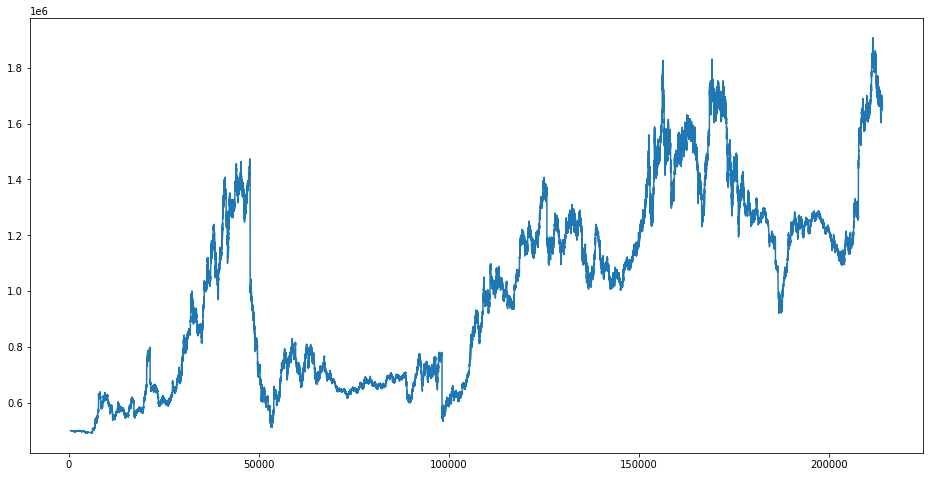

In [13]:
df_to_check.all_cash.plot(figsize = (16, 8))

<AxesSubplot:>

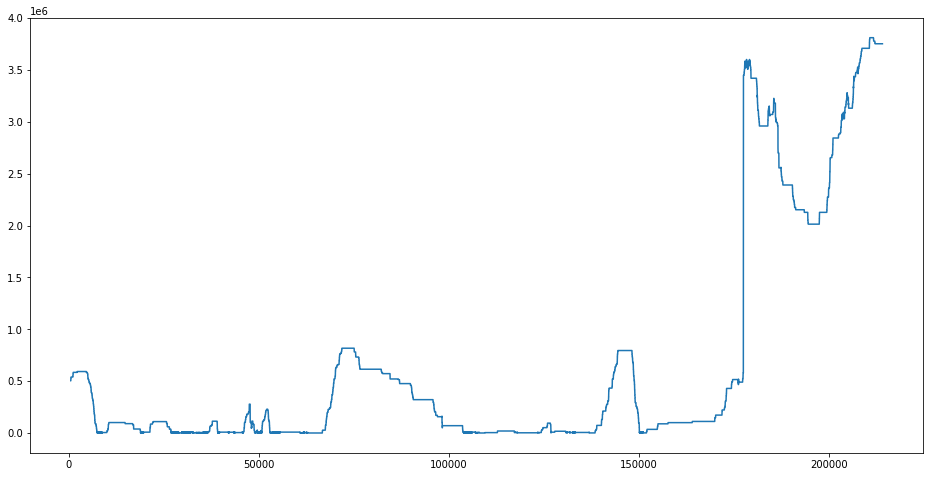

In [14]:
df_to_check.cur_cash.plot(figsize = (16, 8))

In [15]:
a, b = Base_Strategy.signal_times(main, hedge, 28, min_val = 8, max_val = 92)

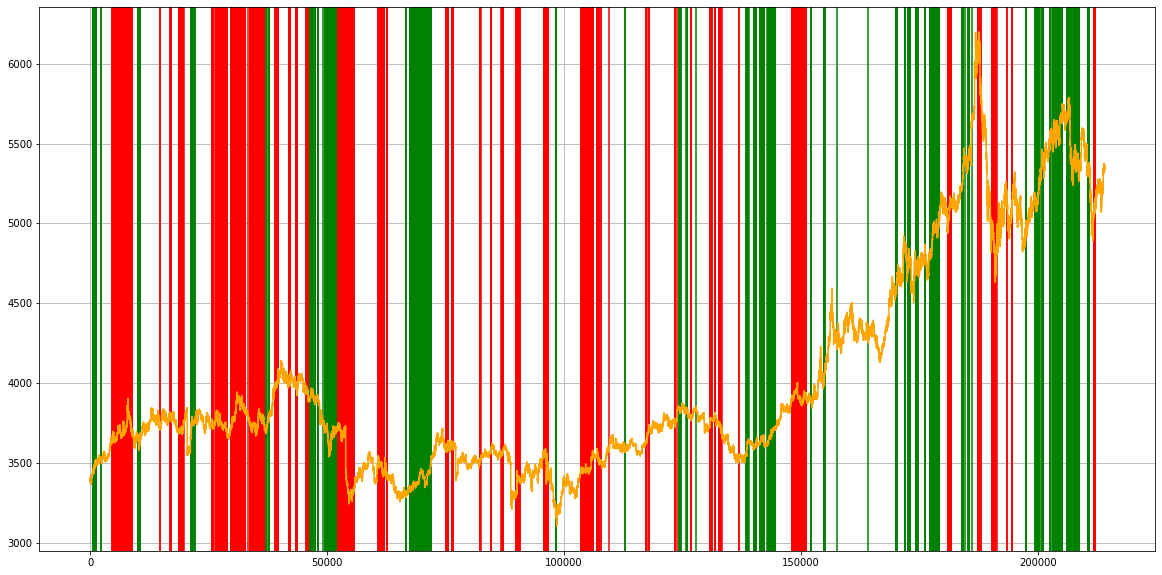

In [16]:
figure(figsize = (20, 10))
for el in a:
    axvline(el, c = 'g')
for el in b:
    axvline(el, c = 'r')
plot(main['close'], c = 'orange')
grid()
show()

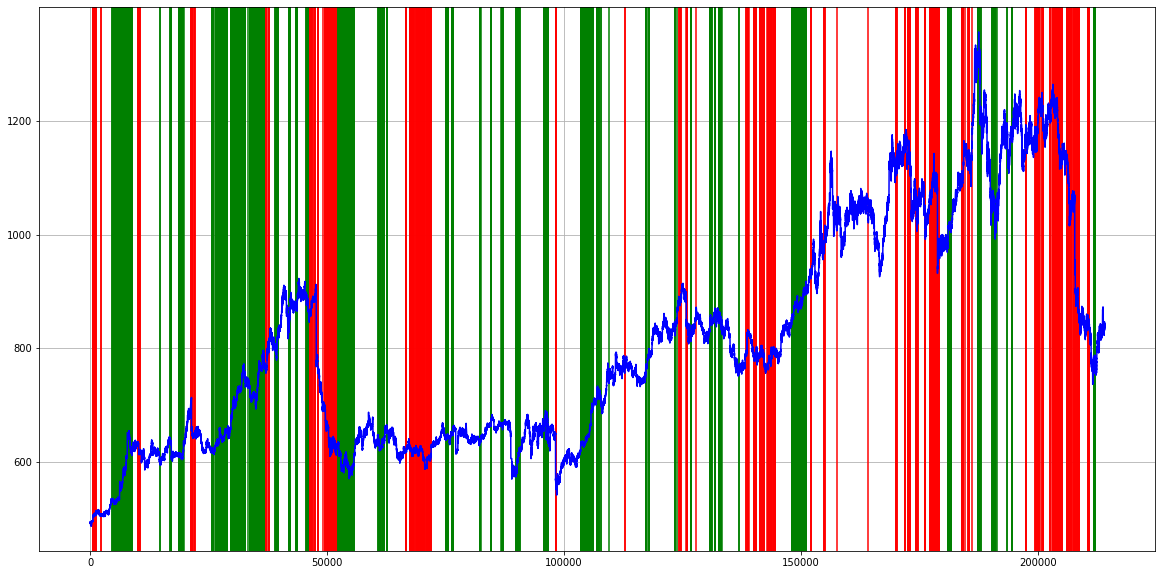

In [17]:
figure(figsize = (20, 10))
for el in a:
    axvline(el, c = 'r')
for el in b:
    axvline(el, c = 'g')
plot(hedge['close'], c ='b')
grid()
show()